In [2]:
pip install lifelines

  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4048 sha256=337ba14e94d0b710c53c8201e6b88d4e20f886a62a9eeb79f5bc6039396cb501
  Stored in directory: c:\users\aggvi\appdata\local\pip\cache\wheels\a8\03\64\8557323821d25118c3a2dc1646996f7a962a8970d4b7d22473
Successfully built autograd-gamma
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.1.1
    Uninstalling typing-extensions-4.1.1:
      Successfully uninstalled typing-extensions-4.1.1
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import pickle
import pingouin as pg
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test

## Define the gene, dataset and groups of interest to plot

In [2]:
gene_name = 'SMYD2'
dataset_name = 'TCGA-BRCA'
survival_type = 'os'

## Import a project

In [3]:
pickle_file = 'C:/Users/AGGVI/STAGE/LysOnc.pickle'
with open(pickle_file, 'rb') as f:
    project = pickle.load(f)

## Load data

In [4]:
data_file = project['data_dir'] + project['datasets'][dataset_name]['data']
data = pd.read_csv(data_file, sep=';')
data.index = data['gene_symbol']
if 'id_gene' in data.columns:
    data.drop(columns=['id_gene', 'gene_symbol'], inplace=True)
data.head()

,TCGA-3C-AAAU-01A,TCGA-3C-AALI-01A,TCGA-3C-AALJ-01A,TCGA-3C-AALK-01A,TCGA-4H-AAAK-01A,TCGA-5L-AAT0-01A,TCGA-5L-AAT1-01A,TCGA-5T-A9QA-01A,TCGA-A1-A0SB-01A,TCGA-A1-A0SD-01A,...,TCGA-UL-AAZ6-01A,TCGA-UU-A93S-01A,TCGA-V7-A7HQ-01A,TCGA-W8-A86G-01A,TCGA-WT-AB41-01A,TCGA-WT-AB44-01A,TCGA-XX-A899-01A,TCGA-XX-A89A-01A,TCGA-Z7-A8R5-01A,TCGA-Z7-A8R6-01A
gene_symbol,,,,,,,,,,,,,,,,,,,,,
ACAD9,3.443010,3.378234,3.410165,3.517439,3.494249,3.553496,3.576522,3.621126,3.304146,3.464956,...,3.514324,3.744753,3.583952,3.533464,2.657228,3.340163,3.357468,3.501044,3.553901,3.733680
ACTBL2,0.064055,0.014212,0.000000,0.020058,0.054501,0.000000,0.043204,0.000000,0.289952,0.026021,...,0.009060,0.000000,0.000000,0.110096,0.000000,0.000000,1.566328,0.022616,0.085425,0.019346
ACTC1,0.211884,0.000000,0.056722,0.012211,0.013498,0.037453,0.052555,0.019061,1.838185,0.208268,...,0.022190,0.000000,0.000000,0.015498,0.067363,0.043064,0.037734,0.000000,0.246104,0.069702
AHNAK,7.186134,5.957148,5.561650,6.006008,6.885628,6.640573,5.702599,5.349263,6.622119,6.723016,...,4.959840,4.353824,5.183995,6.251443,5.132782,4.996484,6.347690,6.429745,5.392860,6.607653
ARHGEF5,2.802131,1.682798,1.795684,2.092850,2.050362,2.244248,1.797387,1.986520,2.174151,2.304803,...,1.951998,2.583760,2.461529,2.681044,2.635429,2.322332,1.972068,1.402395,2.479955,1.906236


## Load clinical annotations

In [5]:
clinical_file = project['data_dir'] + project['datasets'][dataset_name]['clinical']
clinical = pd.read_csv(clinical_file, sep=';', index_col=0)
clinical

,main_gse_number,id_platform,organism,sample_title,sample_source,sex,ethnic_group,age_min,age_max,id_tissue_stage,...,her2_and_cent17_cells_count_clin_shared_days_to_death,her2_cent17_ratio_clin_shared_radiation_therapy,her2_copy_number_brca_shared_her2_neu_and_centromere_17_copy_number_analysis_input_total_number_count,her2_fish_method_brca_shared_metastatic_breast_carcinoma_erbb2_immunohistochemistry_level_result,her2_fish_status_nte_additional_surgery_metastatic_procedure,her2_ihc_percent_positive_brca_shared_breast_carcinoma_progesterone_receptor_status,her2_positivity_method_text_clin_shared_person_neoplasm_cancer_status,pr_positivity_ihc_intensity_score_brca_shared_metastatic_breast_carcinoma_estrogen_receptor_detection_method_text,pr_status_ihc_percent_positive_follow_up_v1_5_follow_up,source_sample_id
id_sample,,,,,,,,,,,,,,,,,,,,,
TCGA-3C-AAAU-01A,TCGA-BRCA,multi,Homo sapiens,197b76a1-a09a-4659-83aa-2c14fd1023a9,Primary Tumor,F,not hispanic or latino,55.37,55.37,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-3C-AALI-01A,TCGA-BRCA,multi,Homo sapiens,0050d7c9-ece9-4b6c-8023-1ff2efcb3c9c,Primary Tumor,F,not hispanic or latino,50.79,50.79,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-3C-AALJ-01A,TCGA-BRCA,multi,Homo sapiens,e355913a-6e4c-4d63-8a53-8be4c5b003b8,Primary Tumor,F,not hispanic or latino,62.60,62.60,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-3C-AALK-01A,TCGA-BRCA,multi,Homo sapiens,2a532346-0008-4af8-99bc-d709585da1d6,Primary Tumor,F,not hispanic or latino,52.26,52.26,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-4H-AAAK-01A,TCGA-BRCA,multi,Homo sapiens,685b5df4-0620-40e2-aa09-0dd736bb5e2b,Primary Tumor,F,not hispanic or latino,50.33,50.33,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-WT-AB44-01A,TCGA-BRCA,multi,Homo sapiens,081947cf-1635-4a57-9903-0c405ead6d84,Primary Tumor,F,not hispanic or latino,NaN,NaN,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-XX-A899-01A,TCGA-BRCA,multi,Homo sapiens,43623706-5604-4f3d-8746-9bfa0b92c0a9,Primary Tumor,F,not hispanic or latino,46.64,46.64,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-XX-A89A-01A,TCGA-BRCA,multi,Homo sapiens,1422b157-eec7-460e-96c8-9121847d283b,Primary Tumor,F,not hispanic or latino,68.49,68.49,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Extract the data corresponding to genes and groups

In [6]:
cox_data = pd.DataFrame(index = data.columns)
cox_data[gene_name] = data.loc[gene_name, cox_data.index]
cox_data['time'] = clinical.loc[cox_data.index, survival_type + '_months']
cox_data['event'] = clinical.loc[cox_data.index, survival_type + '_censor']
cox_data.index.name = 'id_sample'
cox_data.dropna(inplace=True)
cox_data.head()

,SMYD2,time,event
id_sample,,,
TCGA-3C-AAAU-01A,2.529096,134.90,0.0
TCGA-3C-AALI-01A,3.950403,133.50,0.0
TCGA-3C-AALJ-01A,3.723286,49.13,0.0
TCGA-3C-AALK-01A,3.113850,48.27,0.0
TCGA-4H-AAAK-01A,3.467919,11.60,0.0


## Cox proportional hazard model 

In [7]:
cph = CoxPHFitter()
cph.fit(cox_data, duration_col='time', event_col='event', show_progress=False)
cox_pvalue = cph.summary.p[gene_name]
cox_hr = cph.summary['exp(coef)'][gene_name]
cph.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
SMYD2,-0.039921,0.960865,0.1075,-0.250617,0.170776,0.77832,1.186225,0.0,-0.371356,0.710372,0.493353


## Create groups corresponding to up and down-regulated gene

In [8]:
cox_data['group'] = 0
threshold = cox_data[gene_name].median() 
cox_data.loc[cox_data[gene_name]>threshold, 'group'] = 1
cox_data.drop(columns=[gene_name], inplace=True)
cox_data.head()

,time,event,group
id_sample,,,
TCGA-3C-AAAU-01A,134.90,0.0,0
TCGA-3C-AALI-01A,133.50,0.0,1
TCGA-3C-AALJ-01A,49.13,0.0,1
TCGA-3C-AALK-01A,48.27,0.0,0
TCGA-4H-AAAK-01A,11.60,0.0,1


## Logrank test

In [9]:
cph.fit(cox_data, duration_col='time', event_col='event', show_progress=False)
cox_bin_pvalue = cph.summary.p['group']
cox_bin_hr = cph.summary['exp(coef)']['group']
logrank = multivariate_logrank_test(cox_data['time'], cox_data['group'], cox_data['event'])
logrank_pvalue = logrank.p_value
print('Cox p-value for binarized groups = {:.3f}, logrank p-value = {:.3f}'.format(cox_bin_pvalue, logrank_pvalue))

Cox p-value for binarized groups = 0.140, logrank p-value = 0.140


In [11]:
cph.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
group,-0.212502,0.808559,0.143941,-0.494621,0.069617,0.609802,1.072098,0.0,-1.476312,0.13986,2.837944


## Plot Kaplan-Meier survival curves

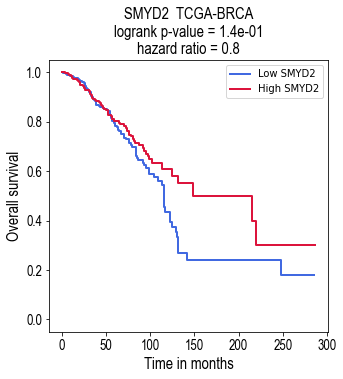

In [10]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
group_labels = {0: 'Low ' + gene_name, 1: 'High ' + gene_name}
group_colors = {0: 'royalblue', 1: 'crimson'}
font = {'fontname':'Arial', 'stretch' : 'condensed', 'fontsize': 16}

kmf = KaplanMeierFitter()
for g in cox_data['group'].unique():
    group_data = cox_data[cox_data['group']==g]
    kmf.fit(group_data['time'], group_data['event'], label=group_labels[g])
    kmf.plot(ax=ax, ci_show=False, show_censors=False, color=group_colors[g], linewidth=2)

title = gene_name + '  ' + dataset_name + '\nlogrank p-value = {:.1e}'.format(logrank_pvalue) + '\nhazard ratio = {:.1f}'.format(cox_bin_hr) 
ax.set_title(title, **font)
ax.set_ylim([-0.05, 1.05])

max_survival_time = round(cox_data['time'].max(), 0)
step_time = 50
ax.set_xlim([0.0 - 0.05*max_survival_time, max_survival_time + 0.05*max_survival_time])

xticks = [int(xi) for xi in np.arange(0, max_survival_time + step_time, step_time)]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks, **font)
        
yticks = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
ax.set_yticks(yticks)
ax.set_yticklabels(yticks, **font)

survival_name = {'os': 'Overall survival', 'dfs': 'Disease-free survial'}
ax.set_ylabel(survival_name[survival_type], **font)
ax.set_xlabel('Time in months', **font)
ax.tick_params(axis='both', labelsize=font['fontsize']-2)